In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import psutil
import os
import time
from torch.utils.data import DataLoader, Dataset
import mat73
import random
import torch.nn as nn
import matplotlib.gridspec as gridspec
import seaborn as sns

In [2]:
# Helper Functions

def calculate_psnr(target, prediction):
    """Calculate Peak Signal-to-Noise Ratio"""
    mse = np.mean((target - prediction) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = np.max(target)
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def calculate_peak_metrics_single(target_spectrum, predicted_spectrum, prominence=0.1):
    """Calculate peak detection metrics for *single* spectra."""
    true_peaks, _ = find_peaks(target_spectrum, prominence=prominence)
    pred_peaks, _ = find_peaks(predicted_spectrum, prominence=prominence)
    matches = 0
    for tp in true_peaks:
        for pp in pred_peaks:
            if abs(tp - pp) <= 1:  # Tolerance of 1 index point
                matches += 1
                break
    return len(true_peaks), len(pred_peaks), matches

def calculate_peak_metrics_patch(target, prediction, prominence=0.1):
    """Calculate peak detection accuracy for full patch predictions"""
    peak_metrics = {'true_peaks': 0, 'predicted_peaks': 0, 'matching_peaks': 0}
    batch_size, num_points, height, width = target.shape
    for b in range(batch_size):
        for h in range(height):
            for w in range(width):
                true_spectrum = target[b, :, h, w]
                pred_spectrum = prediction[b, :, h, w]
                true_peaks, _ = find_peaks(true_spectrum, prominence=prominence)
                pred_peaks, _ = find_peaks(pred_spectrum, prominence=prominence)
                matches = 0
                for tp in true_peaks:
                    for pp in pred_peaks:
                        if abs(tp - pp) <= 1:
                            matches += 1
                            break
                peak_metrics['true_peaks'] += len(true_peaks)
                peak_metrics['predicted_peaks'] += len(pred_peaks)
                peak_metrics['matching_peaks'] += matches
    return peak_metrics

def measure_inference_time(model, input_tensor, device, num_iterations=100):
    """Measure average inference time"""
    model.eval()
    start_time = time.time()
    with torch.no_grad():
        for _ in range(num_iterations):
            _ = model(input_tensor.to(device))
    end_time = time.time()
    return (end_time - start_time) / num_iterations

def count_parameters(model):
    """Count number of trainable parameters"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def measure_memory_usage():
    """Measure current memory usage"""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024  # Convert to MB

def calculate_spatial_consistency(targets, predictions, window_size=3):
    """Calculate spatial consistency metric with handling of constant patches"""
    batch_size, num_points, height, width = targets.shape
    consistency_scores = []
    for b in range(min(batch_size, 100)):
        for t in range(num_points):
            true_patch = targets[b, t]
            pred_patch = predictions[b, t]
            if np.std(true_patch) == 0 or np.std(pred_patch) == 0:
                continue
            try:
                correlation = np.corrcoef(true_patch.flatten(), pred_patch.flatten())[0, 1]
                if not np.isnan(correlation):
                    consistency_scores.append(correlation)
            except:
                continue
    return np.mean(consistency_scores) if consistency_scores else 0.0

def evaluate_model_metrics(model, val_loader, device):
    """Evaluate all model metrics for patch-based models"""
    model.eval()
    metrics = {}
    sample_input, _ = next(iter(val_loader))
    metrics['inference_time'] = measure_inference_time(model, sample_input, device)
    all_targets = []
    all_predictions = []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            targets_np = targets.cpu().numpy()
            outputs_np = outputs.cpu().numpy()
            all_targets.append(targets_np)
            all_predictions.append(outputs_np)
    all_targets = np.concatenate(all_targets)
    all_predictions = np.concatenate(all_predictions)
    metrics['mse'] = np.mean((all_targets - all_predictions) ** 2)
    metrics['mae'] = np.mean(np.abs(all_targets - all_predictions))
    metrics['psnr'] = calculate_psnr(all_targets, all_predictions)
    r2_scores = []
    batch_size, num_points, height, width = all_targets.shape
    for h in range(height):
        for w in range(width):
            true_spectra = all_targets[:, :, h, w].reshape(-1)
            pred_spectra = all_predictions[:, :, h, w].reshape(-1)
            r2_scores.append(r2_score(true_spectra, pred_spectra))
    metrics['r2_score'] = np.mean(r2_scores)
    metrics['peak_metrics'] = calculate_peak_metrics_patch(all_targets, all_predictions)
    metrics['memory_usage'] = measure_memory_usage()
    metrics['num_parameters'] = count_parameters(model)
    metrics['spatial_consistency'] = calculate_spatial_consistency(all_targets, all_predictions)
    return metrics

In [ ]:
# UNet Model Definition

class SpatialAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Conv2d(in_channels, in_channels//8, kernel_size=1),
            nn.BatchNorm2d(in_channels//8),
            nn.LeakyReLU(0.1),
            nn.Conv2d(in_channels//8, in_channels, kernel_size=1),
            nn.Sigmoid()
        )
    def forward(self, x):
        attention_weights = self.attention(x)
        return x * attention_weights

class ResidualDoubleConvWithAttention(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1),
            nn.Dropout2d(0.1),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1)
        )
        self.attention = SpatialAttention(out_channels)
        self.residual = nn.Identity() if in_channels == out_channels else \
                       nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        identity = self.residual(x)
        x = self.double_conv(x)
        x = self.attention(x)
        return x + identity

class UNetWithAttention(nn.Module):
    def __init__(self):
        super(UNetWithAttention, self).__init__()
        self.conv1 = ResidualDoubleConvWithAttention(8, 64)
        self.pool1 = nn.MaxPool2d(2, padding=1)
        self.conv2 = ResidualDoubleConvWithAttention(64, 128)
        self.bridge_conv = ResidualDoubleConvWithAttention(128, 256)
        self.upconv = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv3 = ResidualDoubleConvWithAttention(192, 128)
        self.final_conv = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            SpatialAttention(64),
            nn.Conv2d(64, 32, kernel_size=1)
        )
        self.apply(self._init_weights)
    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
    def forward(self, x):
        conv1 = self.conv1(x)
        x = self.pool1(conv1)
        conv2 = self.conv2(x)
        x = self.bridge_conv(conv2)
        x = self.upconv(x)
        x = x[:, :, :9, :9]
        x = torch.cat([x, conv1], dim=1)
        x = self.conv3(x)
        x = self.final_conv(x)
        return x

In [4]:
# Data Loading and Preprocessing

def load_and_preprocess_data(file_path):
    """Loads data, handles NaNs, normalizes, and returns as torch tensors."""
    data = mat73.loadmat(file_path)
    input_noisy_np = data['input_noisy']
    ref_np = data['ref']
    input_noisy_np = np.nan_to_num(input_noisy_np, nan=0.0)
    input_noisy_torch = torch.tensor(np.transpose(input_noisy_np, (3, 2, 0, 1)), dtype=torch.float32)
    ref_torch = torch.tensor(np.transpose(ref_np, (3, 2, 0, 1)), dtype=torch.float32)
    input_mean = input_noisy_torch.mean()
    input_std = input_noisy_torch.std()
    input_noisy_torch = (input_noisy_torch - input_mean) / input_std
    return input_noisy_torch, ref_torch, input_mean, input_std

class T1Dataset(Dataset):
    def __init__(self, input_data, target_data):
        self.input_data = input_data
        self.target_data = target_data
    def __len__(self):
        return len(self.input_data)
    def __getitem__(self, idx):
        return self.input_data[idx], self.target_data[idx]

In [ ]:
# Peak Finding and Voxel Selection

def count_peaks(signal, prominence=0.05):
    """Counts the number of peaks in a signal."""
    peaks, _ = find_peaks(signal, prominence=prominence)
    return len(peaks)

def find_examples_for_peaks(targets_np, num_peaks, num_examples=4, batch_idx=0):
    """
    Finds up to `num_examples` voxels with the target number of peaks.
    """
    found_examples = []
    for r in range(targets_np.shape[2]):
        for c in range(targets_np.shape[3]):
            spectrum = targets_np[batch_idx, :, r, c]
            if count_peaks(spectrum) == num_peaks:
                found_examples.append((batch_idx, r, c))
                if len(found_examples) >= num_examples:
                    return found_examples
    return found_examples

In [17]:
# Plotting Functions

def plot_single_voxel_spectrum(target_spectrum, predicted_spectrum, title, input_spectrum=None):
    """Plots a single voxel's target and predicted spectra using Seaborn."""
    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(8, 6))
        palette = sns.color_palette("muted")
        plt.plot(target_spectrum, label='Target', color=palette[0])
        plt.plot(predicted_spectrum, label='Prediction', color=palette[1], linestyle='--')

        if input_spectrum is not None:
            input_spectrum_rescaled = (input_spectrum - input_spectrum.min()) / (input_spectrum.max() - input_spectrum.min())
            input_spectrum_rescaled *= np.max(target_spectrum)
            plt.plot(np.linspace(0, len(target_spectrum) - 1, len(input_spectrum)), input_spectrum_rescaled, label='Input (Rescaled)', color=palette[2], linestyle=':')

        plt.title(title)
        plt.xlabel('T1 Index (32 points)')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.show()

def plot_heatmap_comparison(targets_np, outputs_np, example_idx):
    """Plots heatmaps, ensuring all subplots are displayed."""
    num_t1_points = targets_np.shape[1]
    fig, axes = plt.subplots(4, 8, figsize=(20, 10))
    axes = axes.flatten()

    for t1_idx in range(num_t1_points):
        ax = axes[t1_idx]
        combined_image = np.concatenate([targets_np[example_idx, t1_idx, :, :],
                                         outputs_np[example_idx, t1_idx, :, :]], axis=1)
        im = ax.imshow(combined_image, cmap='viridis')
        ax.set_title(f'T1 Point {t1_idx + 1}', fontsize=10)
        ax.axis('off')
        ax.axvline(x=8.5, color='white', linewidth=2)

    for j in range(num_t1_points, len(axes)):
        axes[j].axis('off')

    fig.colorbar(im, ax=axes[-1], orientation='vertical', fraction=0.046, pad=0.04)
    fig.suptitle('Target (Left) vs. Prediction (Right) Heatmaps', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [7]:
sns.set()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetWithAttention().to(device)
model_path = '../models/spatial_signal_full_patch/saved_models/best_unet_model_attention_4.pt'
file_path = '../data/training_data_T1_3D_9x9x32x47932_noise0.05.mat'
input_noisy_torch, ref_torch, input_mean, input_std = load_and_preprocess_data(file_path)
val_size = int(0.2 * len(input_noisy_torch))
val_input = input_noisy_torch[len(input_noisy_torch) - val_size:]
val_target = ref_torch[len(input_noisy_torch) - val_size:]
val_dataset = T1Dataset(val_input, val_target)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

print(f"Loading best model from {model_path}...")
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded model checkpoint with validation loss: {checkpoint['val_loss']:.6f}")

print("\nEvaluating on the entire validation set...")
final_metrics = evaluate_model_metrics(model, val_loader, device)
print("\nFinal Model Evaluation (Full Validation Set):")
print(f"  MSE: {final_metrics['mse']:.6f}")
print(f"  MAE: {final_metrics['mae']:.6f}")
print(f"  PSNR: {final_metrics['psnr']:.2f} dB")
print(f"  R² Score: {final_metrics['r2_score']:.4f}")
print(f"  Peak Detection Accuracy: {final_metrics['peak_metrics']['matching_peaks'] / final_metrics['peak_metrics']['true_peaks']:.2%}")
print(f"  Average Inference Time: {final_metrics['inference_time'] * 1000:.2f} ms")
print(f"  Memory Usage: {final_metrics['memory_usage']:.1f} MB")
print(f"  Number of Parameters: {final_metrics['num_parameters']:,}")
print(f"  Spatial Consistency: {final_metrics['spatial_consistency']:.4f}")


print("\nPredicting and visualizing a single batch...")
inputs, targets = next(iter(val_loader))
inputs, targets = inputs.to(device), targets.to(device)
with torch.no_grad():
    outputs = model(inputs)
inputs_np = inputs.cpu().numpy()
targets_np = targets.cpu().numpy()
outputs_np = outputs.cpu().numpy()
example_idx = 0

Loading best model from ../models/spatial_signal_full_patch/saved_models/best_unet_model_attention_4.pt...
Loaded model checkpoint with validation loss: 0.001604

Evaluating on the entire validation set...


C:\Users\trpha\AppData\Local\Temp\ipykernel_16832\971973513.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)



Final Model Evaluation (Full Validation Set):
  MSE: 0.001604
  MAE: 0.020441
  PSNR: 27.93 dB
  R² Score: 0.6095
  Peak Detection Accuracy: 47.01%
  Average Inference Time: 6.74 ms
  Memory Usage: 1708.5 MB
  Number of Parameters: 1,820,816
  Spatial Consistency: 0.4413

Predicting and visualizing a single batch...


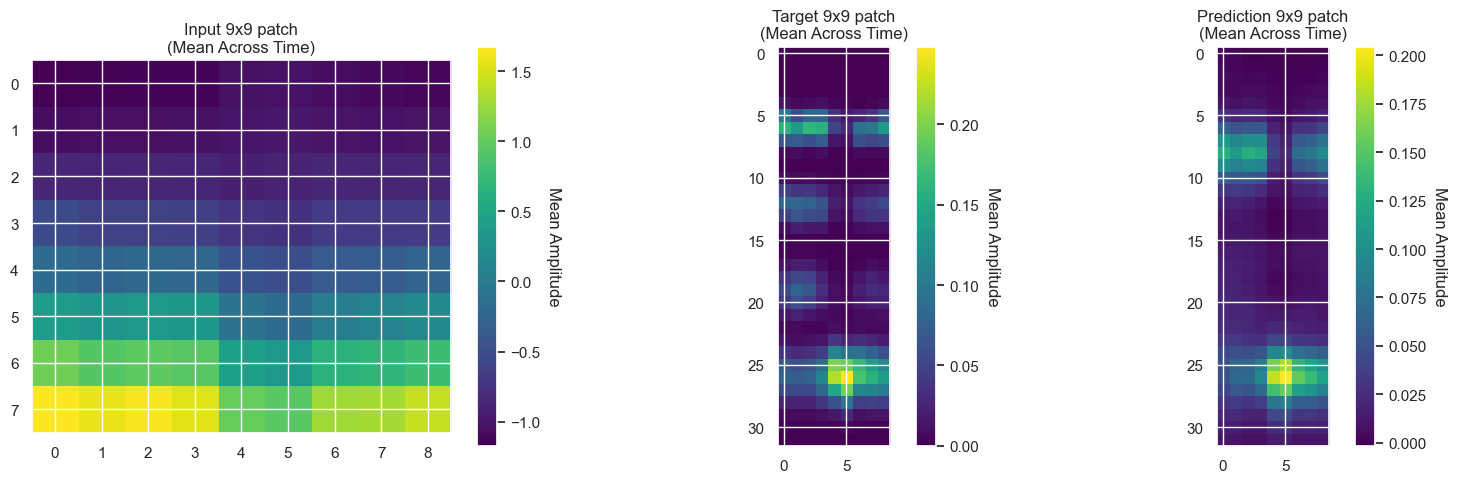

In [9]:
# Visualize Input, Target, and Prediction Patches
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(np.mean(inputs_np[example_idx], axis=1), cmap='viridis')
plt.title('Input 9x9 patch\n(Mean Across Time)')
cbar1 = plt.colorbar()
cbar1.set_label('Mean Amplitude', rotation=270, labelpad=15)

plt.subplot(132)
plt.imshow(np.mean(targets_np[example_idx], axis=1), cmap='viridis')
plt.title('Target 9x9 patch\n(Mean Across Time)')
cbar2 = plt.colorbar()
cbar2.set_label('Mean Amplitude', rotation=270, labelpad=15)

plt.subplot(133)
plt.imshow(np.mean(outputs_np[example_idx], axis=1), cmap='viridis')
plt.title('Prediction 9x9 patch\n(Mean Across Time)')
cbar3 = plt.colorbar()
cbar3.set_label('Mean Amplitude', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

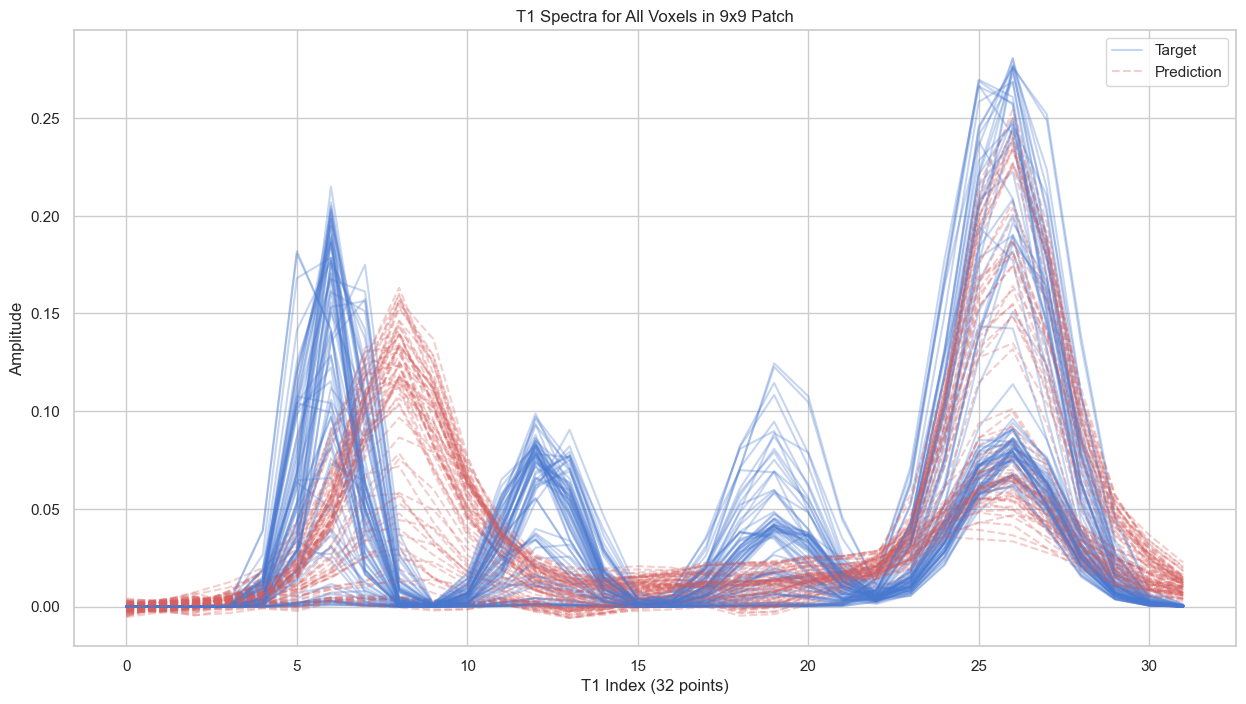

In [10]:
# Visualize all spectra in the 9x9 Patch
with sns.axes_style("whitegrid"):
    plt.figure(figsize=(15, 8))
    palette = sns.color_palette("muted")
    for i in range(9):
        for j in range(9):
            plt.plot(targets_np[example_idx, :, i, j], color=palette[0], alpha=0.3, label='Target' if i == 0 and j == 0 else "")
            plt.plot(outputs_np[example_idx, :, i, j], color=palette[3], linestyle='--', alpha=0.3, label='Prediction' if i == 0 and j == 0 else "")
    plt.title('T1 Spectra for All Voxels in 9x9 Patch')
    plt.xlabel('T1 Index (32 points)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

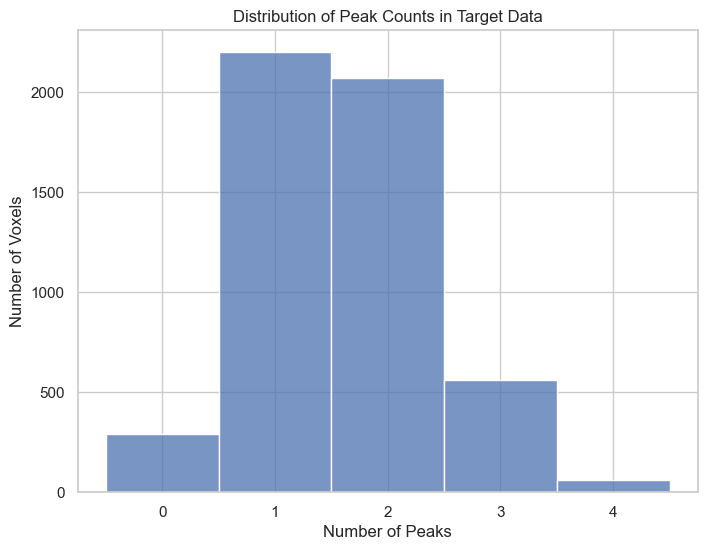

In [11]:
# Peak Distribution
all_peak_counts = []
for batch_idx in range(targets_np.shape[0]):
    for r in range(targets_np.shape[2]):
        for c in range(targets_np.shape[3]):
            spectrum = targets_np[batch_idx, :, r, c]
            all_peak_counts.append(count_peaks(spectrum))

with sns.axes_style("whitegrid"):
    plt.figure(figsize=(8, 6))
    sns.histplot(all_peak_counts, bins=range(1, max(all_peak_counts) + 2), discrete=True)
    plt.title('Distribution of Peak Counts in Target Data')
    plt.xlabel('Number of Peaks')
    plt.ylabel('Number of Voxels')
    plt.show()

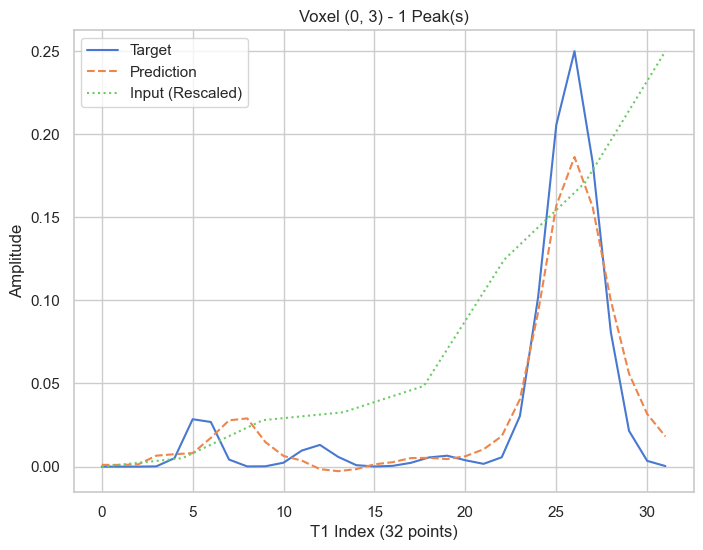

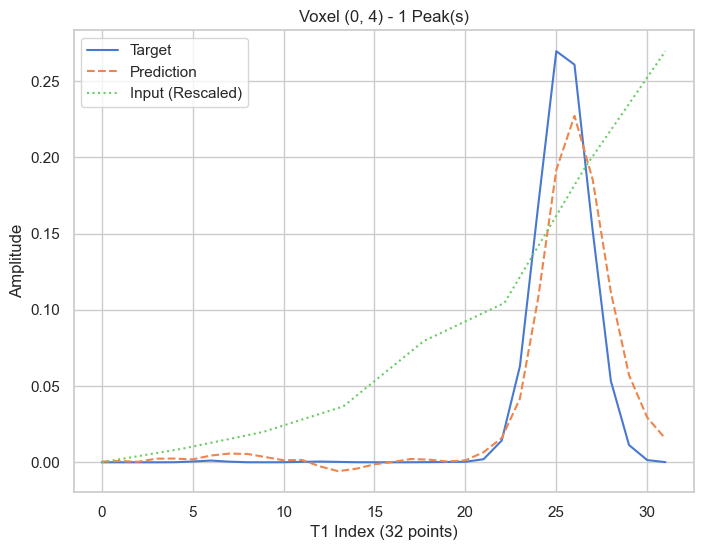

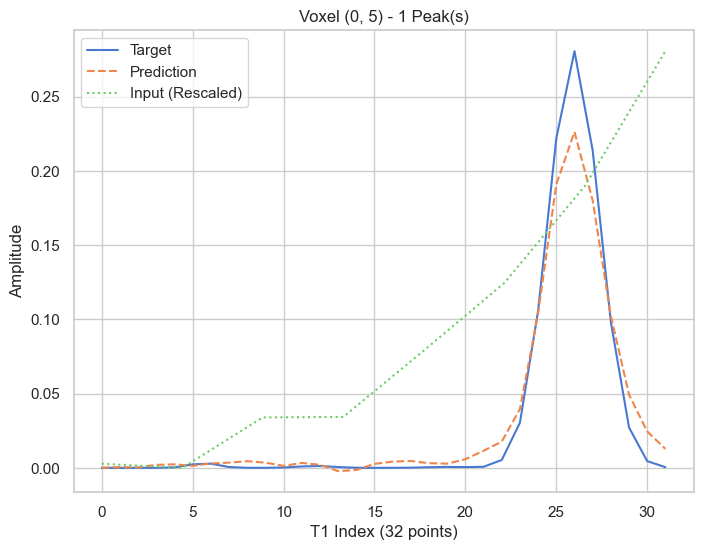

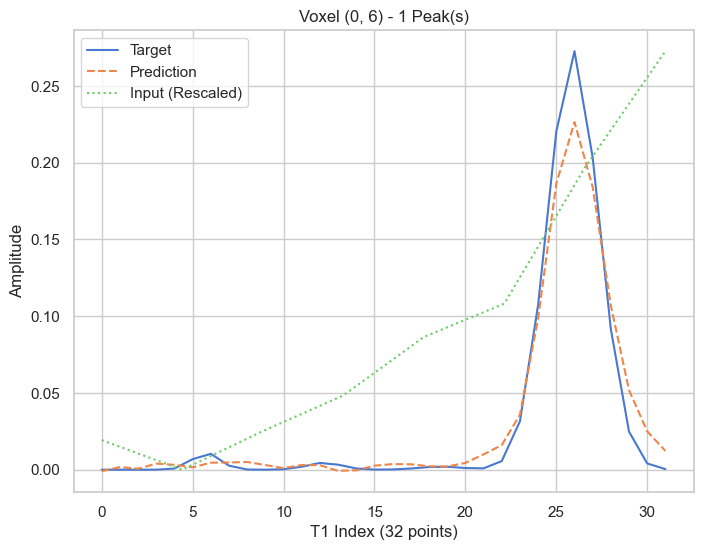

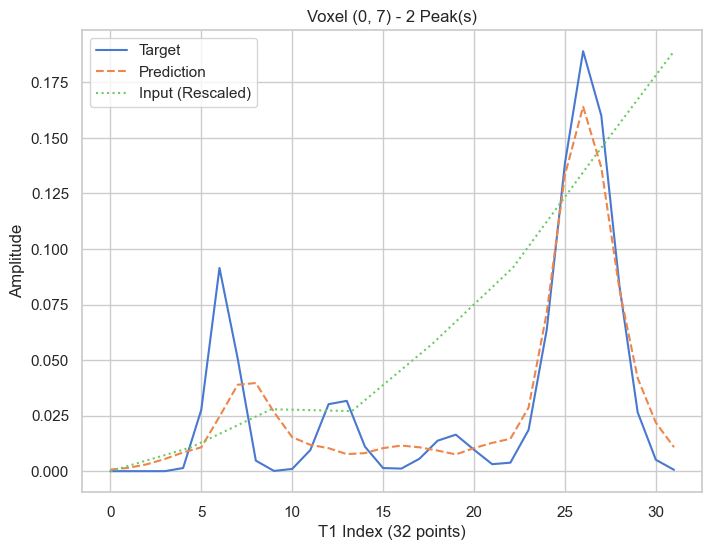

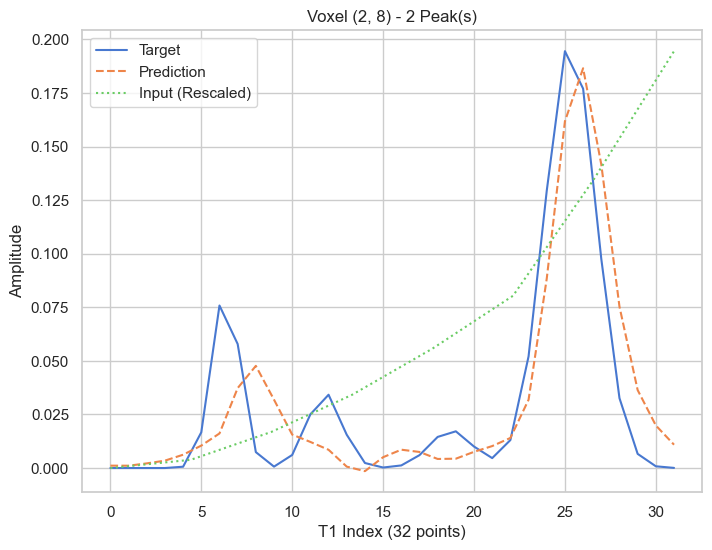

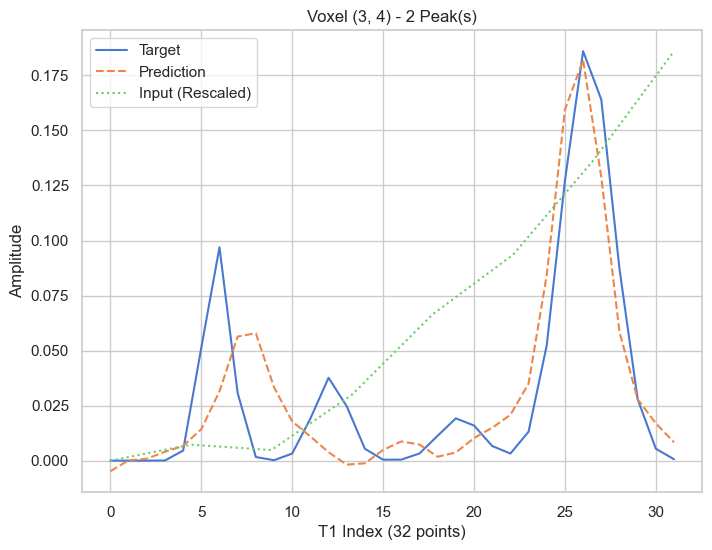

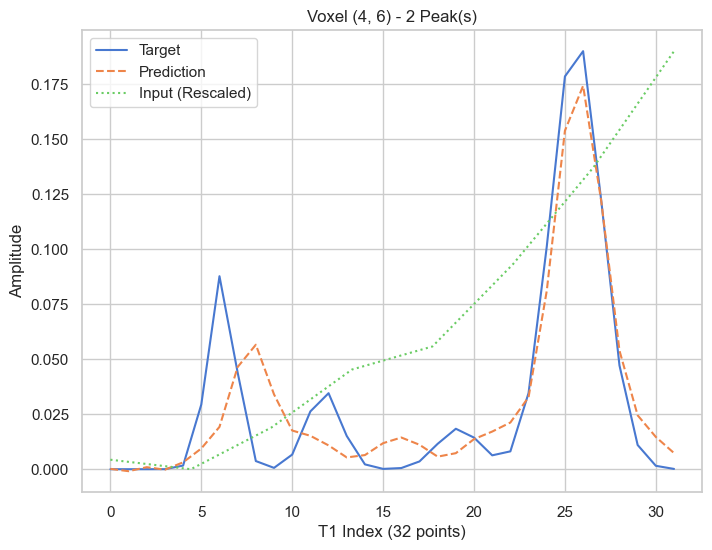

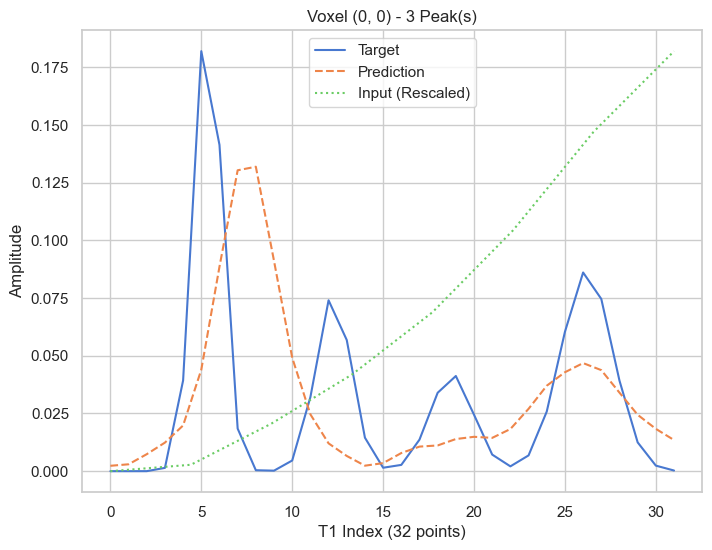

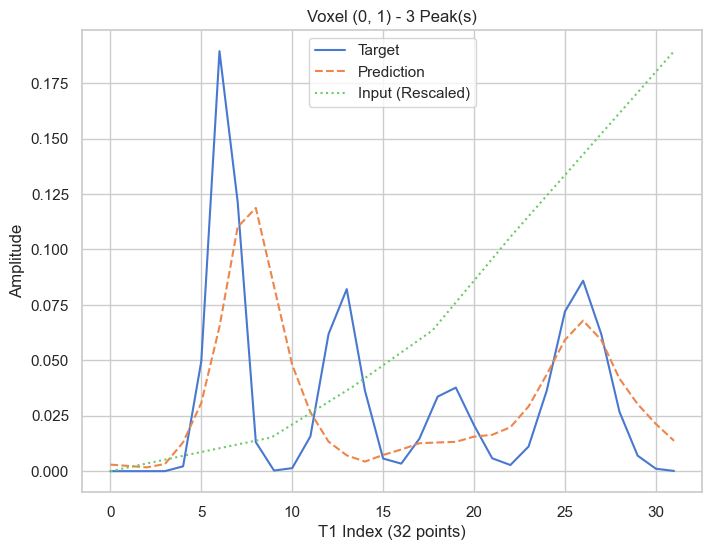

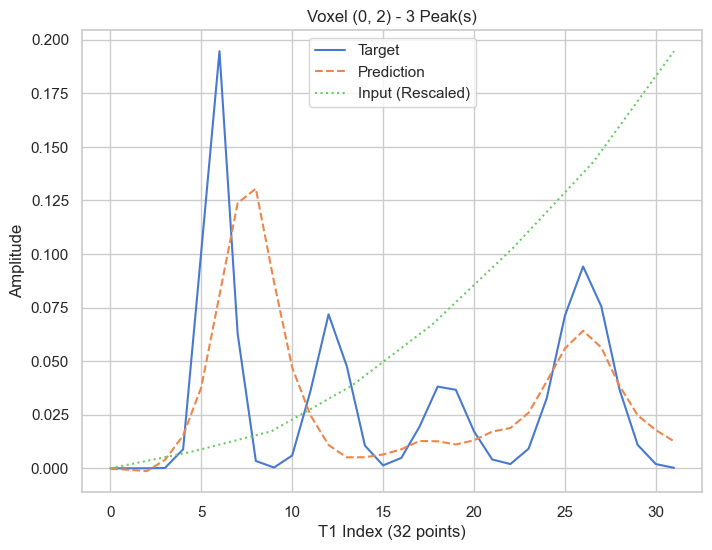

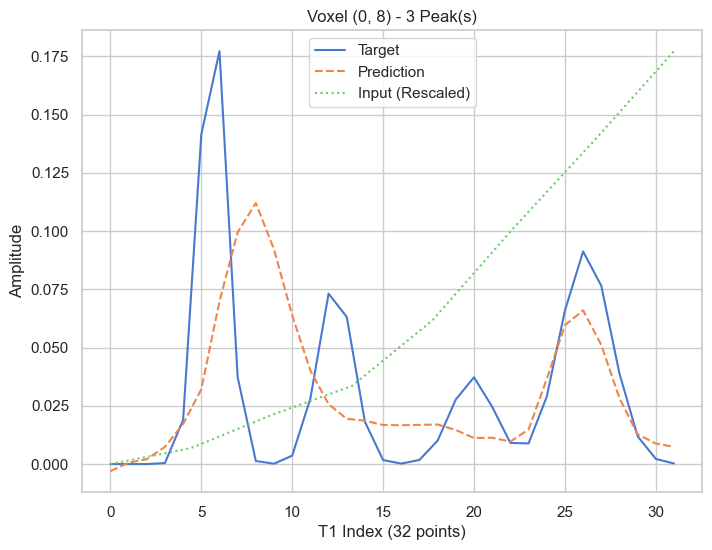

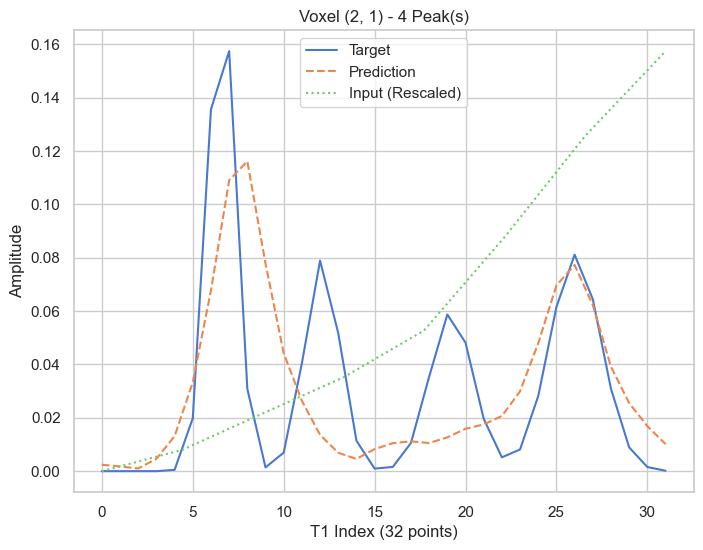

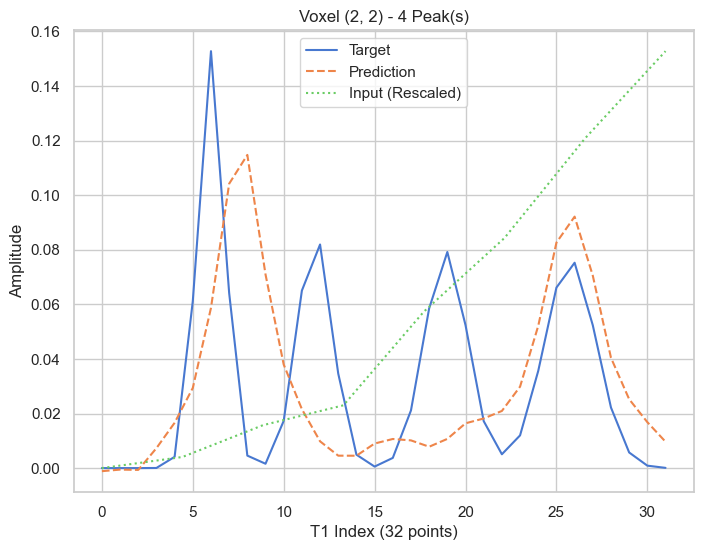

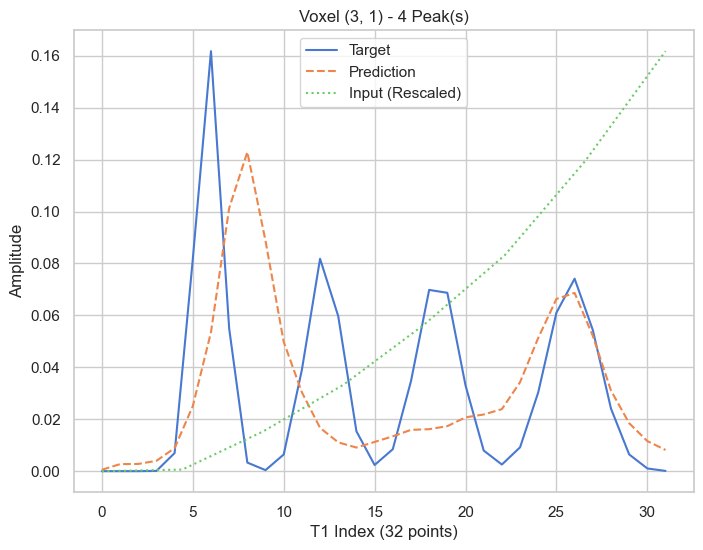

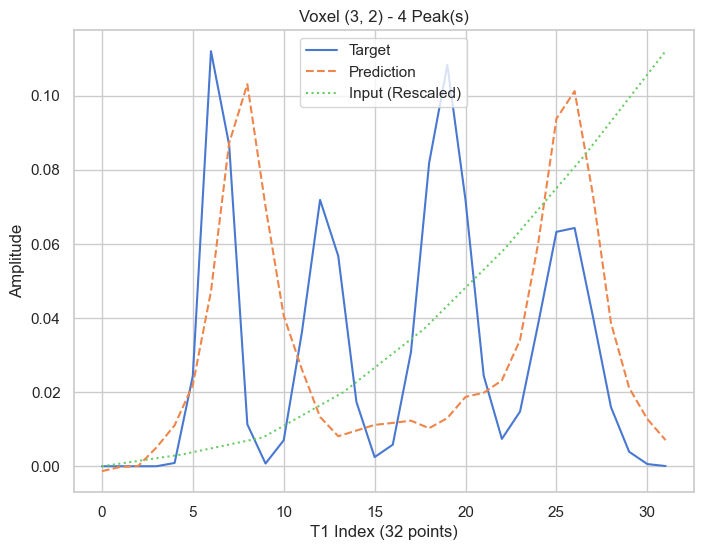

In [12]:
# Find and Visualize Voxels with Specific Peak Counts
peak_counts = [1, 2, 3, 4]
num_examples_per_peak = 4
batch_idx = 0

for num_peaks in peak_counts:
    found_examples = find_examples_for_peaks(targets_np, num_peaks, num_examples_per_peak, batch_idx=batch_idx)
    if found_examples:
        for voxel_coords in found_examples:
            b, r, c = voxel_coords
            target_spectrum = targets_np[b, :, r, c]
            predicted_spectrum = outputs_np[b, :, r, c]
            input_spectrum = inputs_np[b, :, r, c]

            title = f'Voxel ({r}, {c}) - {num_peaks} Peak(s)'
            plot_single_voxel_spectrum(target_spectrum, predicted_spectrum, title, input_spectrum)
    else:
        print(f"Could not find {num_examples_per_peak} voxels with {num_peaks} peaks in batch {batch_idx}.")

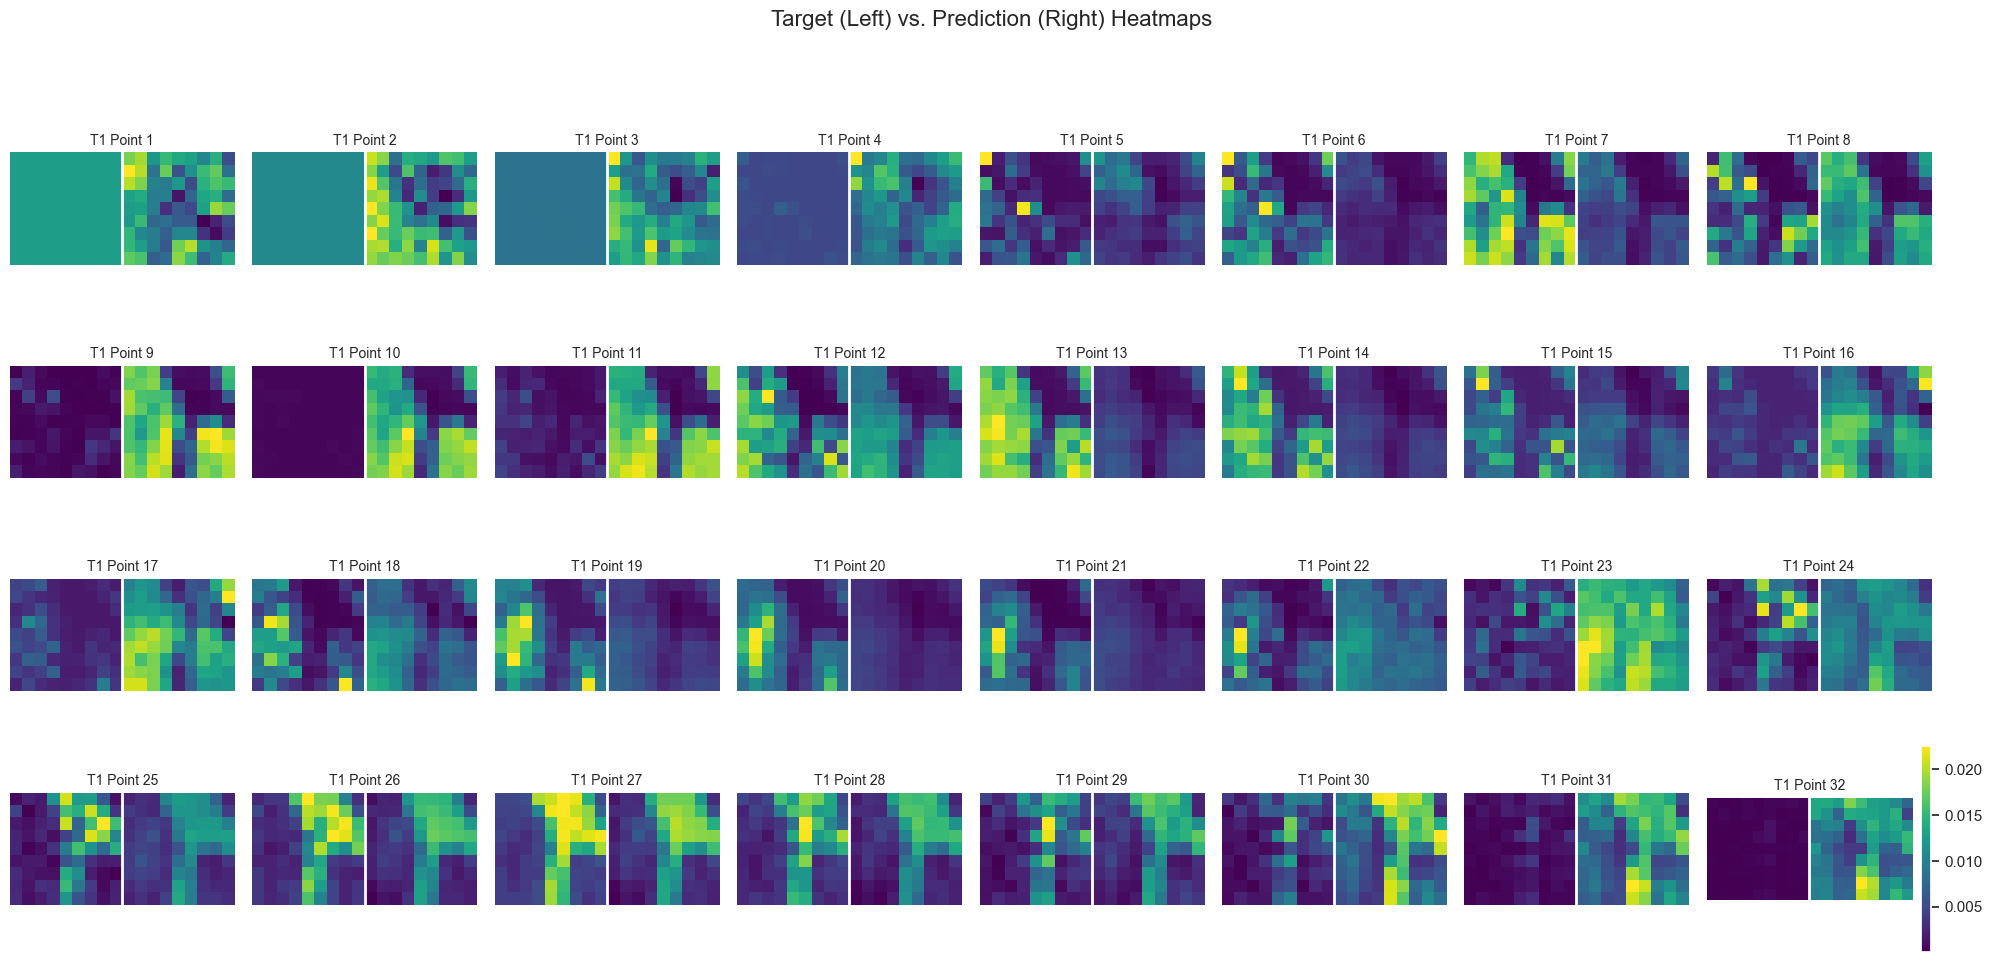

In [18]:
# Heatmap Comparison
plot_heatmap_comparison(targets_np, outputs_np, example_idx)

In [14]:
# Print Metrics
patch_mse = np.mean((targets_np[example_idx] - outputs_np[example_idx])**2)
patch_mae = np.mean(np.abs(targets_np[example_idx] - outputs_np[example_idx]))
print(f"\nFull 9x9 patch MSE: {patch_mse:.6f}")
print(f"Full 9x9 patch MAE: {patch_mae:.6f}")
voxel_mses = []
for i in range(9):
    for j in range(9):
        mse = np.mean((targets_np[example_idx, :, i, j] - outputs_np[example_idx, :, i, j])**2)
        voxel_mses.append(mse)
print(f"\nMean Voxel MSE: {np.mean(voxel_mses):.6f}")
print(f"Std Voxel MSE: {np.std(voxel_mses):.6f}")
print(f"Min Voxel MSE: {np.min(voxel_mses):.6f}")
print(f"Max Voxel MSE: {np.max(voxel_mses):.6f}")


Full 9x9 patch MSE: 0.001323
Full 9x9 patch MAE: 0.021717

Mean Voxel MSE: 0.001323
Std Voxel MSE: 0.000816
Min Voxel MSE: 0.000141
Max Voxel MSE: 0.002703
